In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

parameter_dir = "../topology_code/"


#####################################################################################
# Creating a dictionary containing the info from the topology file
#####################################################################################
stuff = ["[AtomTypes]","[Bonds]","[Angles]","[ImproperDihedrals]","[Dihedrals]","[LJ]","[Charges]"]
with open(parameter_dir+"benzene.top") as file:
    lines = []
    for line in file:
        lines.append(line)

dic = {}
for thing in stuff:
    dic[thing] = []

def add2dic(line,thing, count):
    if len(line.split()) != 2:
        nlines=natoms
    else:
        nlines=int(line.split()[1])
    for i in range(nlines):
        #print(lines[count+i+1])
        dic[thing].append(lines[count+i+1].split("\t"))
    return nlines

count = -1
for line in lines:
    count += 1
    if line.startswith("[AtomTypes]"):
        natoms = int(line.split()[1])
    for thing in stuff:
        if line.startswith(thing):
            add2dic(line,thing,count)

print("\n-----------------------------------------------------------------------")
print("The created dictionary contains the following content\nwith the number of lines written on the right.")
print("The first line of each block given below as well:\n")
for thing in dic:
    #print(thing,"\n",dic[thing])
    print(thing,len(dic[thing]))
    print(dic[thing][0])
    print()
print("-----------------------------------------------------------------------")



-----------------------------------------------------------------------
The created dictionary contains the following content
with the number of lines written on the right.
The first line of each block given below as well:

[AtomTypes] 12
['1', 'C', 'CA', '12.01\n']

[Bonds] 12
['1', '2', '0.14', '392459.2\n']

[Angles] 18
['CA-CA-CA', '2', '1', '6', '120.0', '527.184\n']

[ImproperDihedrals] 36
['X-X-CA-HA', '1', '2', '6', '7', '4', '180.0', '4.6024', '2\n']

[Dihedrals] 48
['X-CA-CA-X', '3', '2', '1', '6', '9', '180.0', '15.167', '2\n']

[LJ] 12
['1', '3.39967×10^-01', '3.59824×10^-01\n']

[Charges] 12
['1', '-0.14289394335936967\n']

-----------------------------------------------------------------------


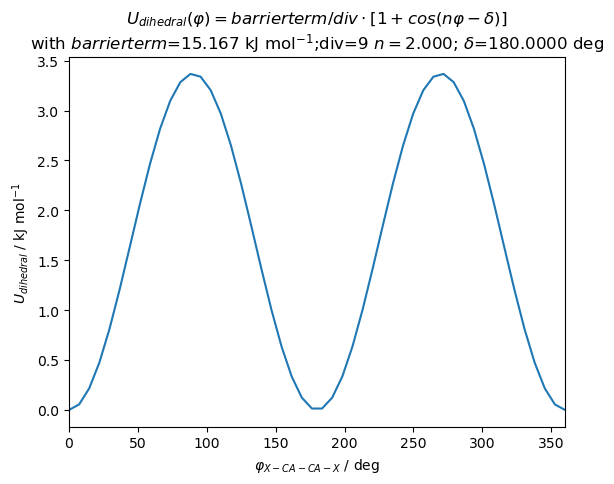

In [17]:
def plot_U_bonds(dic,entryline):
    atom1=int(dic["[Bonds]"][entryline][0])
    atom2=int(dic["[Bonds]"][entryline][1])
    b0=float(dic["[Bonds]"][entryline][2])
    kb=float(dic["[Bonds]"][entryline][3])
    b=np.linspace(0,0.5) # in nm
    
    atom1_name=dic["[AtomTypes]"][atom1+1][1]
    atom2_name=dic["[AtomTypes]"][atom2+1][1]
    atoms = atom1_name+"-"+atom2_name
    
    atom1_type=dic["[AtomTypes]"][atom1+1][2]
    atom2_type=dic["[AtomTypes]"][atom2+1][2]
    atoms = atom1_type+"-"+atom2_type
    
    U_bonds = 1/2*kb*(b-b0)**2
    
    fig = plt.figure()
    plt.plot(b,U_bonds)
    plt.title("$U_{bonds}(b) = 0.5 \cdot k_b \cdot(b-b_0)^2$\nwith $k_b$=%.1f kJ mol$^{-1}$nm$^{-2}$ and $b_0$=%.4f nm"%(kb,b0))
    plt.xlabel("$b_{%s}$ / nm"%atoms)
    plt.ylabel("$U_{bonds}$ / kJ mol$^{-1}$")
    #plt.close()
    
    plt.xlim([0,0.5])
    plt.ylim([0,1e4])
    
    plt.savefig("U_bonds.png", dpi=300)
    plt.close()
    return

def plot_U_angles(dic,entryline):
    atoms=dic["[Angles]"][entryline][0]
    th0=float(dic["[Angles]"][entryline][4])
    cth=float(dic["[Angles]"][entryline][5])
    th=np.linspace(0,360,361) # in deg
    
    U_angles = 1/2*cth*(th-th0)**2
    
    fig = plt.figure()
    plt.plot(th,U_angles)
    plt.title("$U_{angles}(θ) = 0.5 \cdot k_{θ} \cdot(θ-θ_0)^2$\nwith $k_{θ}$=%.1f kJ mol$^{-1}$deg$^{-2}$ and $θ_0$=%.4f deg"%(cth,th0))
    plt.xlabel("$θ_{%s}$ / deg"%atoms)
    plt.ylabel("$U_{angles}$ / kJ mol$^{-1}$")
    
    plt.xlim([0,360])
    plt.ylim([0,2e7])

    plt.savefig("U_angles.png", dpi=300)
    plt.close()
    return

def plot_U_dihedral(dic,entryline):
    atoms=dic["[Dihedrals]"][entryline][0]
    div=int(dic["[Dihedrals]"][entryline][5])
    phase=float(dic["[Dihedrals]"][entryline][6]) #phase /deg
    barrier_term=float(dic["[Dihedrals]"][entryline][7]) 
    periodicity=int(dic["[Dihedrals]"][entryline][8])
    
    phi=np.linspace(0,360) # in deg

    U_dihedral = barrier_term/div*(1+np.cos((periodicity*phi-phase)/360*(2*np.pi)))
    
    
    plt.figure()
    plt.plot(phi,U_dihedral)
    plt.title("$U_{dihedral}(φ) = barrierterm/div \cdot[1+cos(nφ-δ)]$\nwith $barrierterm$=%.3f kJ mol$^{-1}$;div=%i $n=%.3f$; $δ$=%.4f deg"%(barrier_term,div,periodicity,phase))
    plt.xlabel("$φ_{%s}$ / deg"%atoms)
    plt.ylabel("$U_{dihedral}$ / kJ mol$^{-1}$")
    
    plt.xlim([0,360])
    #plt.ylim([0,2e7])
    #plt.close()
    #plt.savefig("U_dihedral.png", dpi=300)
    #plt.close()
    return
plot_U_dihedral(dic,6)



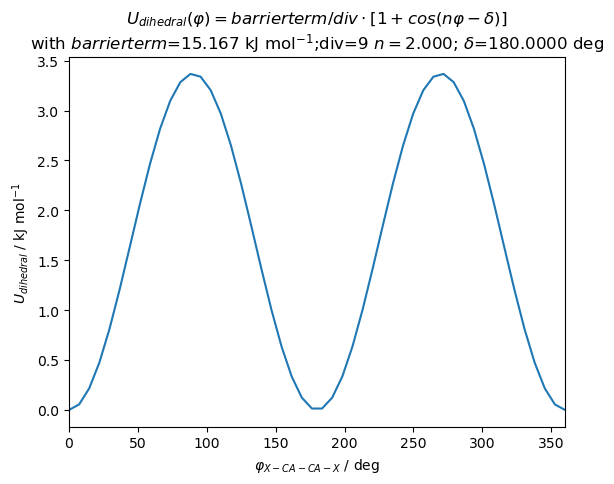

In [14]:
plot_U_bonds(dic,0)
plot_U_angles(dic,6)
plot_U_dihedral(dic,6)

In [4]:
line_in_csv = 1
with open(parameter_dir+"ffnonbonded.csv") as file:
    lines = []
    for line in file:
        lines.append(line.split(","))

atoms = lines[line_in_csv][0].strip()+"-"+lines[line_in_csv][0].strip()
atnum = int(lines[line_in_csv][1])
mass = float(lines[line_in_csv][2])
charge = float(lines[line_in_csv][3])
sigma = float(lines[line_in_csv][4])
eps = float(lines[line_in_csv][5])


print(lines[0])
print(lines[line_in_csv])

dist=np.linspace(0,0.5) # in nm

U_dihedral = kd*(1+np.cos(pn*phi+phase))


plt.figure()
plt.plot(phi,U_dihedral)
plt.title("$U_{LJ}(r) = 4 ε [ (σ/r)^12 - (σ/r)^6 ]$ \n with ε = .3%f and σ = .3%f "%(eps,sigma))
plt.xlabel("$r_{%s}$ / deg"%atoms)
plt.ylabel("$U_{LJ}$ / kJ mol$^{-1}$")

plt.xlim([0,360])
#plt.ylim([0,2e7])
#plt.close()

plt.savefig("U_dihedrals.png", dpi=300)
plt.close()


FileNotFoundError: [Errno 2] No such file or directory: '../topology_code/ffnonbonded.csv'